In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

from astropy.io import fits

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MAIN.zip

In [2]:
from astropy.visualization import ImageNormalize, ZScaleInterval

In [8]:
directories = [
    "/content/MAIN/JELLYFISH", "/content/MAIN/NON_JELLYFISH"
]
os.mkdir("pngs/")
os.mkdir("pngs/JELLYFISH")
os.mkdir("pngs/NON_JELLYFISH")

def get_stamps_data(directories):
    """
    directories: list
        List of directories where the files reside.
    
    Notes
    -----
    'stamps_Halpha': Detected in H-alpha emission.
    'stamps_non_halpha': Not detected in H-alpha emission.
    'stamps_jellyfish_HSTF606W': 73 jellyfish galaxies (certainly detected in halpha).

    """
    data = []
    labels = []
    for directory in directories:
        label = 1 if directory == "/content/MAIN/JELLYFISH" else 0
        for galaxy_name in os.listdir(directory):
            if galaxy_name.startswith("hst_") and galaxy_name.endswith(".fits"):
                galaxy = fits.getdata(os.path.join(directory, galaxy_name))
                # `hst_stamp_gal_60579.fits` in `stamps_Halpha` has (250, 238) size, ignoring.
                if galaxy.shape != (250, 250):
                    continue
                  
                labels.append(label)

                galaxy = galaxy[50:250-50, 50:250-50]
                norm = ImageNormalize(galaxy, interval=ZScaleInterval())
                plt.imshow(galaxy, norm=norm)
                plt.savefig(f'pngs/{directory.split("/")[-1]}/{galaxy_name.split(".")[0]}.png')
    return labels

labels = get_stamps_data(directories)

In [27]:
import cv2

In [13]:
import glob

data = []
for i, folder in enumerate(["/content/pngs/JELLYFISH", "/content/pngs/NON_JELLYFISH"]):
  for img in glob.glob(f"{folder}/*.png"):
    image = cv2.imread(img).ravel()
    if i == 0:
      image = np.append(image, i)
    elif i == 1:
      image = np.append(image, i)
    data.append(image)
data = np.array(data)

In [14]:
data.shape

(623, 373249)

The histogram suggests that most of values are around to zero mark (this data was not zero-meaned and unit-variance).

Ideas:
- Can use histogram equalization to evenly spread the histogram? Since intensity values are narrow, a naive approach might increase global contrast and/or unwanted artifacts/gradients. So can use adaptive HE?

In [35]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
import plotly.express as px

# Change default plotly renderer
import plotly.io as pio
pio.renderers.default = "browser"

In [37]:
# This cell would draw all possible PC{i} vs PC{j} plots.
n_components = 5
pca = PCA(n_components=n_components)
components = pca.fit_transform(data_scaled)
total_var = pca.explained_variance_ratio_.sum() * 100

plot_labels = {str(i): f"PC {i+1}" for i in range(n_components)}
# px.scatter_matrix(
#     components,
#     color=labels,
#     dimensions=range(n_components),
#     labels=plot_labels,
#     title=f'Total Explained Variance: {total_var:.2f}%',
# )

### Visualizing principal axes after PCA

In [ ]:
axes = pca.components_  # From documentation, pca.components_ gives the principal axes
axes.shape

(5, 62500)

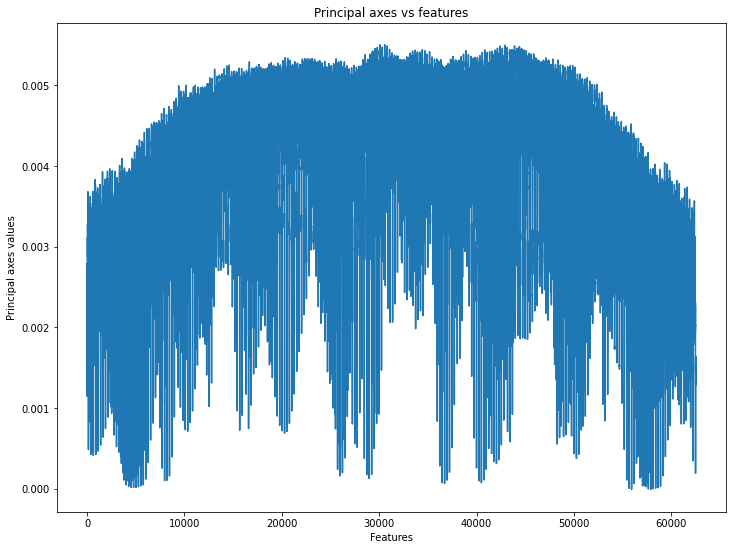

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.title("Principal axes vs features")
plt.xlabel("Features")
plt.ylabel("Principal axes values")
ax.plot(axes[0]);

On the x-axis are the features (62500 of them) and y-axis shows the first principal axes (i.e. the axes along which maximum variance of the dataset was explained). Positive values indicate a positive correlation between that feature and that principal axes. In the above plot, the first principal axes was plotted. It shows the central features (~between 20000 and 50000) are the most inflencing (positively), which is expected since the galaxy is only at the center and other regions are mostly black.

### Using Non-negative matrix factorization

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
copy_data = np.copy(data)
copy_data[copy_data < 0] = 0
copy_data[copy_data < 0]

array([], dtype=float32)

In [ ]:
nmf = NMF(n_components=2)
comps = nmf.fit_transform(copy_data)
comps.shape

/home/yash/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



(625, 2)

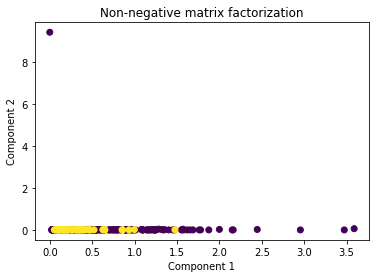

In [ ]:
plt.title("Non-negative matrix factorization")
plt.xlabel("Component 1");
plt.ylabel("Component 2");
plt.scatter(comps[:, 0], comps[:, 1], c=labels);

### Using PCA
(unsupervised and linear)

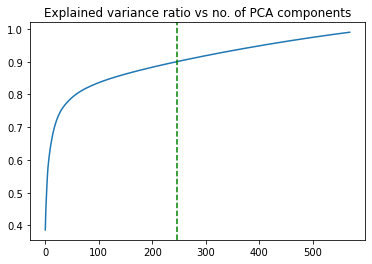

In [ ]:
pca = PCA(n_components=0.99)
principal_components = pca.fit_transform(data_scaled)

exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(exp_var);

ninety_percent = np.where(exp_var > 0.9)[0][0] + 1
plt.axvline(x=ninety_percent, ls="--", c="green", label="90%");
plt.title("Explained variance ratio vs no. of PCA components")
plt.show()

In [ ]:
principal_components.shape

(625, 570)

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)
exp_var = np.cumsum(pca.explained_variance_ratio_)
print(exp_var)

[0.3863221 0.447123 ]


In [ ]:
# PCs corresponding to each class.
jelly_components = principal_components[labels == 1]
non_jelly_components = principal_components[labels == 0]

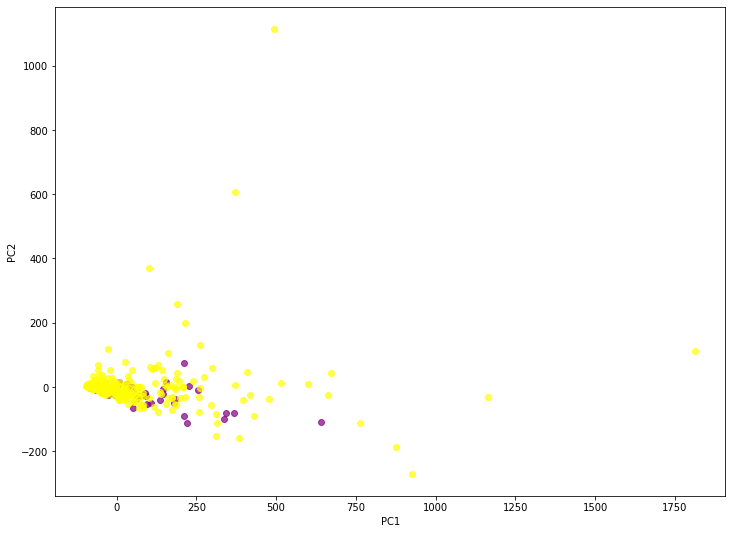

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

scatter_colors = ["purple", "yellow"]

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# Scatter.
ax.scatter(jelly_components[:, 0], jelly_components[:, 1], c=scatter_colors[0], alpha=0.7, label="jellyfish");
ax.scatter(non_jelly_components[:, 0], non_jelly_components[:, 1], c=scatter_colors[1], alpha=0.7, label="non-jellyfish");

### Using Factor Analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis

In [ ]:
fa = FactorAnalysis(n_components=2)
comps = fa.fit_transform(data)
comps.shape

(625, 2)

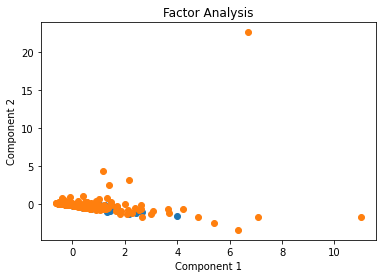

In [ ]:
jelly_comps = comps[labels==1]
non_jelly_comps = comps[labels==0]

plt.scatter(jelly_comps[:, 0], jelly_comps[:, 1]);
plt.title("Factor Analysis")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.scatter(non_jelly_comps[:, 0], non_jelly_comps[:, 1]);

### Using TSVD
This might not yield good results since we use this for sparse data generally. Instead use PCA if data is dense.

No need to center the features. If we center the features and then use `TruncatedSVD`, then it is the same as PCA.

In [ ]:
tsvd = TruncatedSVD(n_components=2)
data_reduced = tsvd.fit_transform(data)

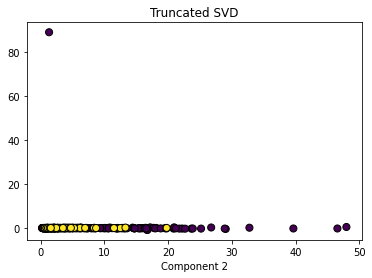

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels, s=50, edgecolor='k');
ax.set_title("Truncated SVD");
ax.set_xlabel("Component 1");
ax.set_xlabel("Component 2");

In [ ]:
expvar = np.cumsum(tsvd.explained_variance_ratio_)
print(expvar)

[0.33832094 0.47040677]


### Using t-SNE
##### (unsupervised and non-linear)

For very large datasets, t-SNE could take a lot of time. Hence, another dimensionality reduction procedure, like PCA, generally helps in reducing some time.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2)  # Use random_state=<int> for reproducible results.
data_reduced = tsne.fit_transform(data_scaled)

In [ ]:
tsne.kl_divergence_, tsne.embedding_.shape, data_reduced.shape

(1.7431676387786865, (625, 2), (625, 2))

In [ ]:
np.all(data_reduced == tsne.embedding_)

True

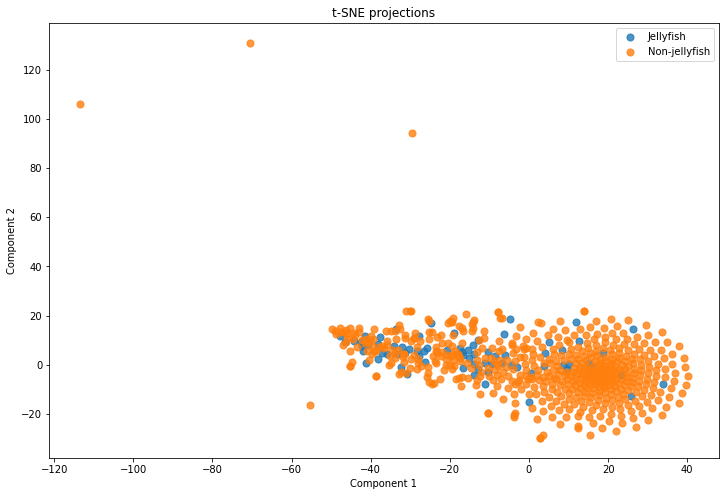

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("t-SNE projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_embedding = tsne.embedding_[labels==1]
nj_embedding = tsne.embedding_[labels==0]
ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, c="purple", alpha=0.8, label="Jellyfish");
ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, c="yellow", alpha=0.8, label="Non-jellyfish");
ax.legend();

Individual scatter plots with marginal histograms

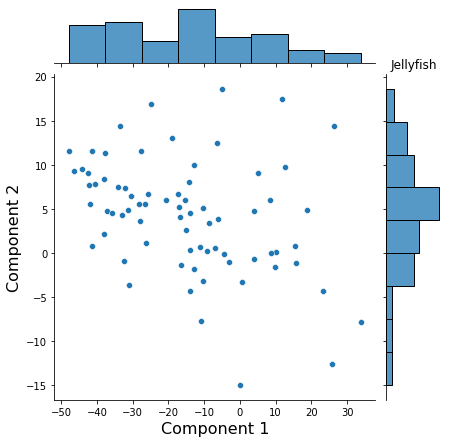

In [ ]:
plot1 = sns.jointplot(x=j_embedding[:, 0], y=j_embedding[:, 1], kind="scatter");
plt.title("Jellyfish");
plot1.set_axis_labels('Component 1', 'Component 2', fontsize=16);

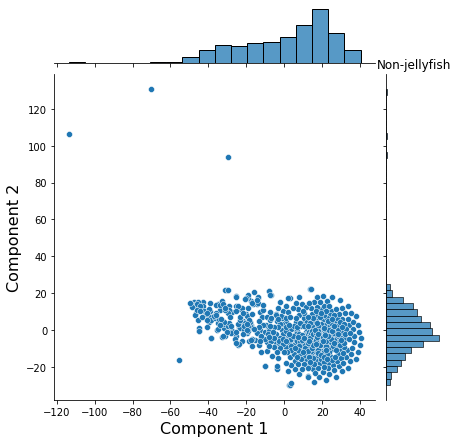

In [ ]:
plot2 = sns.jointplot(x=nj_embedding[:, 0], y=nj_embedding[:, 1], kind="scatter");
plt.title("Non-jellyfish");
plot2.set_axis_labels('Component 1', 'Component 2', fontsize=16);

Till now, only t-SNE seems to closely cluster points that distinguishes them.

Since t-SNE is quadratic in the no. of samples, we can try to use PCA + t-SNE so that after using PCA, we can work on only the important parts of the data.

In [ ]:
pca = PCA(n_components=0.99)
principal_components = pca.fit_transform(data_scaled)
tsne = TSNE(n_components=2)  # Use random_state=<int> for reproducible results.
pca_tsne_reduced = tsne.fit_transform(principal_components)

In [ ]:
pca_tsne_reduced.shape

(625, 2)

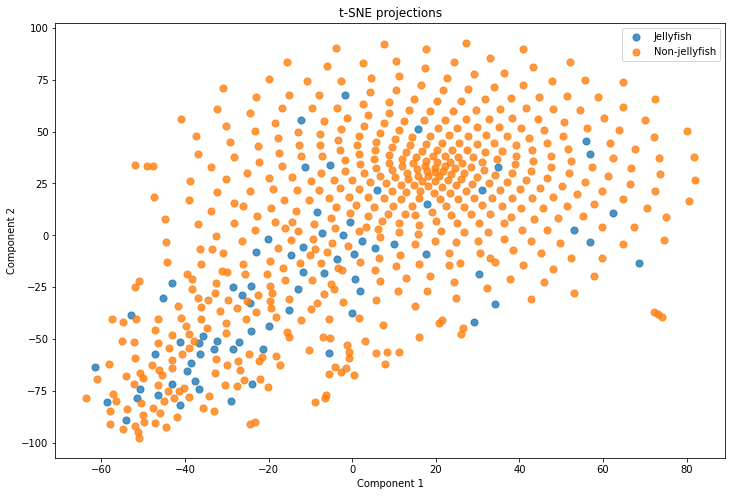

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("t-SNE projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_embedding = pca_tsne_reduced[labels==1]
nj_embedding = pca_tsne_reduced[labels==0]
ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, alpha=0.8, label="Jellyfish");
ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, alpha=0.8, label="Non-jellyfish");
ax.legend();

This approach is slightly sub-optimal compared to directly using t-SNE since the dense cluster of non-jellyfish galaxies is now not seen.

### Using ISOMAP

In [ ]:
from sklearn.manifold import Isomap

In [ ]:
iso = Isomap(n_neighbors=8, n_components=2)
iso_components = iso.fit_transform(data)

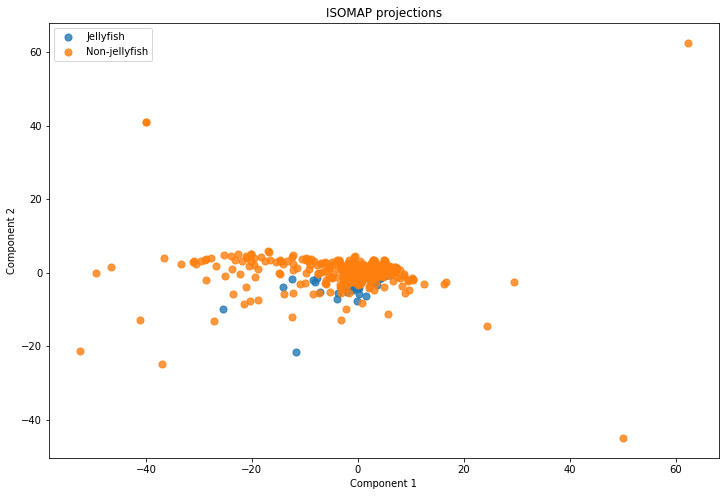

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("ISOMAP projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_iso_components = iso_components[labels==1]
nj_iso_components = iso_components[labels==0]
ax.scatter(j_iso_components[:, 0], j_iso_components[:, 1], s=50, alpha=0.8, label="Jellyfish");
ax.scatter(nj_iso_components[:, 0], nj_iso_components[:, 1], s=50, alpha=0.8, label="Non-jellyfish");
ax.legend();

### Using UMAP
(unsupervised)

In [10]:
!pip install umap-learn

In [11]:
import umap.umap_ as umap

In [15]:
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [18]:
labels=np.array(labels)

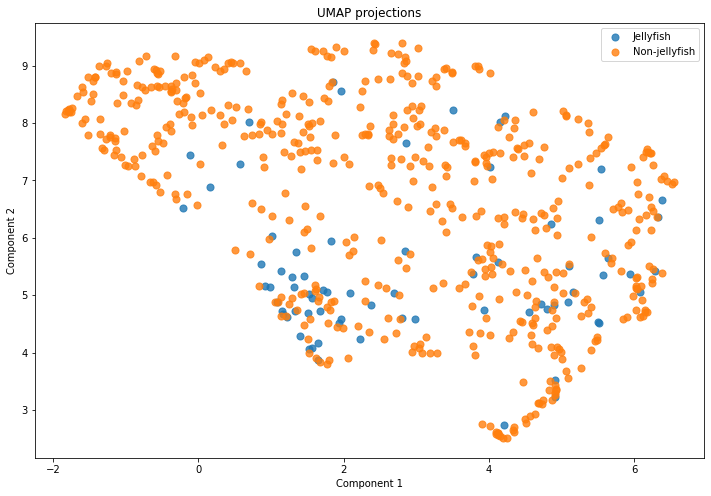

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("UMAP projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_embedding = embedding[labels==1]
nj_embedding = embedding[labels==0]
ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, alpha=0.8, label="Jellyfish");
ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, alpha=0.8, label="Non-jellyfish");
ax.legend();

### Clustering based on J-Classes

### Using FFT + PCA

In [ ]:
def apply_fft(img):
    """
    img: 1D flattened image array.

    """
    img = img.reshape(250, 250)
    fft = np.fft.fft2(img)
    fft_feature = np.column_stack([fft.real, fft.imag])
    fft_feature = fft_feature.flatten()
    return fft_feature

fft_data = np.apply_along_axis(apply_fft, 1, data)
fft_data

array([[ 2.76171041e+02, -2.43557151e+02,  1.66398065e+02, ...,
        -9.02146305e+00,  5.43049741e+00, -7.56813082e+00],
       [ 3.31207740e+02, -2.81641928e+02,  1.60956320e+02, ...,
        -2.78955023e+00, -1.34962063e-01, -1.00061600e+01],
       [ 2.04152681e+02, -1.18694068e+02,  1.37960654e+02, ...,
        -3.01957922e+00,  8.55203608e+00,  1.19135840e+01],
       ...,
       [ 7.38671793e+02, -3.22495602e+02,  5.11386478e+01, ...,
         1.75524388e+01, -1.83593326e+01, -4.52480503e+00],
       [ 7.93559624e+02, -6.05503124e+02,  3.63450849e+02, ...,
        -2.47415957e+01,  1.85735083e+01,  1.66649295e+00],
       [ 1.75075245e+02, -1.13401595e+02,  5.93063787e+01, ...,
        -3.03238288e+00, -6.88888435e-01, -7.10594849e+00]])

In [ ]:
fft_data.shape

(625, 125000)

In [ ]:
scaler = StandardScaler()
fft_data_scaled = scaler.fit_transform(fft_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(fft_data_scaled)

In [ ]:
scatter_colors = ["purple", "yellow"]

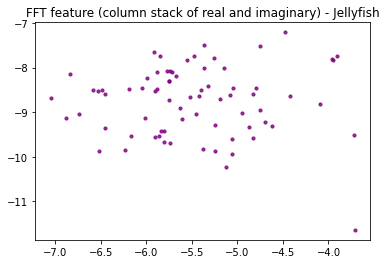

In [ ]:
fig, ax = plt.subplots(1, 1)

j_comps = principal_components[labels==1]
nj_comps = principal_components[labels==0]

ax.scatter(j_comps[:, 0], j_comps[:, 1], s=10, alpha=0.8, c="purple", label="Jellyfish");
ax.set_title("FFT feature (column stack of real and imaginary) - Jellyfish");

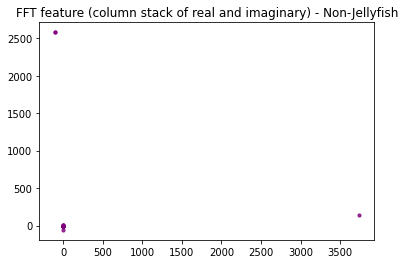

In [ ]:
plt.scatter(nj_comps[:, 0], nj_comps[:, 1], s=10, alpha=0.8, c="purple", label="Non-jellyfish");
plt.title("FFT feature (column stack of real and imaginary) - Non-Jellyfish");

### 1D and 2D Power Spectrums

2D

In [ ]:
from turbustat.statistics import PowerSpectrum

In [ ]:
fits.open("stamps_jellyfish_HSTF606W/hst_stamp_gal_10154.fits")[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  250                                                  
NAXIS2  =                  250                                                  
EXTNAME = 'SCI     '           /                                                
EXTVER  =                    1 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EQUINOX =                2000. / equinox of celestial coord. system             
IRAF-TLM= '09:41:32 (27/07/2006)' / Time of last modification                   
DATE    = '2006-06-22T17:45:32' / Date FITS file was generated                  
INHERIT =                    T / inherit the primary header                     
EXPNAME = 'j96e07dgq        

In [ ]:
jellyfish_dir = "stamps_jellyfish_HSTF606W"
def get_2d_power_spec(filename):
    hdu = fits.open(os.path.join(jellyfish_dir, filename))[0]
    pspec = PowerSpectrum(hdu, header=hdu.header)
    pspec.run(verbose=False)
    return pspec.ps2D

In [ ]:
jellyfish_dir = "stamps_jellyfish_HSTF606W"
pspecs_2d = []
for image in os.listdir(jellyfish_dir):
    if image.startswith("hst") and image.endswith(".fits"):
        hdu = fits.open(os.path.join(jellyfish_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_2d.append(pspec.ps2D.ravel())
pspecs = np.array(pspecs_2d)
np.savetxt("pspecs_jellyfish_2d.txt", pspecs)

In [ ]:
jellyfish_data = np.loadtxt("pspecs_jellyfish_2d.txt")
jellyfish_data.shape

(73, 62500)

In [ ]:
pspecs_2d = []
halpha_dir = "stamps_Halpha/"
for image in os.listdir(halpha_dir):
    if image.startswith("hst") and image.endswith(".fits") and image != "hst_stamp_gal_60579.fits":
        hdu = fits.open(os.path.join(halpha_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_2d.append(pspec.ps2D.ravel())
pspecs = np.array(pspecs_2d)
np.savetxt("pspecs_halpha_2d.txt", pspecs)

In [ ]:
pspecs_2d = []
non_halpha_dir = "stamps_non_halpha/"
for image in os.listdir(non_halpha_dir):
    if image.startswith("hst") and image.endswith(".fits"):
        hdu = fits.open(os.path.join(non_halpha_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_2d.append(pspec.ps2D.ravel())
pspecs = np.array(pspecs_2d)
np.savetxt("pspecs_non_halpha_2d.txt", pspecs)

In [ ]:
non_halpha = np.loadtxt("pspecs_non_halpha_2d.txt")
non_halpha.shape

(187, 62500)

In [ ]:
halpha = np.loadtxt("pspecs_halpha_2d.txt")
halpha.shape

(365, 62500)

In [ ]:
pspec_data = np.vstack([jellyfish_data, non_halpha, halpha])
pspec_data.shape

(625, 62500)

In [ ]:
import h5py

with h5py.File('two_d_pspecs.h5', 'w') as hf:
    hf.create_dataset("2d_specs.h5",  data=pspec_data)

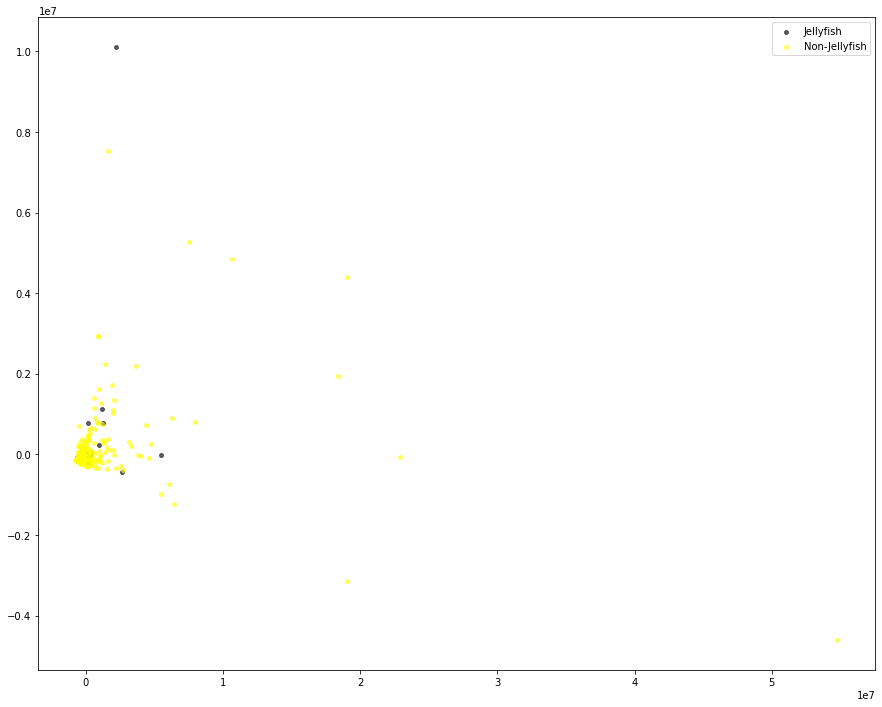

In [ ]:
pca = PCA(n_components=2)
pspec_data_scaled = pca.fit_transform(pspec_data)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

j_comps = pspec_data_scaled[labels==1]
nj_comps = pspec_data_scaled[labels==0]

ax.scatter(j_comps[:, 0], j_comps[:, 1], s=15, alpha=0.6, c="black", label="Jellyfish");
ax.scatter(nj_comps[:, 0], nj_comps[:, 1], s=15, alpha=0.6, c="yellow", label="Non-Jellyfish");
ax.legend();

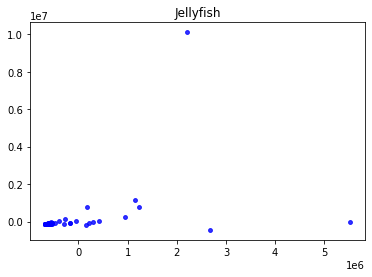

In [ ]:
plt.scatter(j_comps[:, 0], j_comps[:, 1], s=15, alpha=0.8, c="blue", label="Jellyfish");
plt.title("Jellyfish");

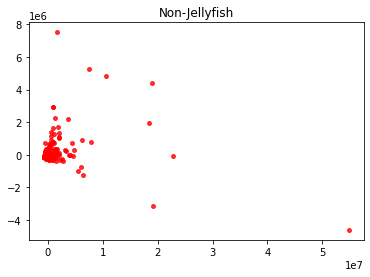

In [ ]:
plt.scatter(nj_comps[:, 0], nj_comps[:, 1], s=15, alpha=0.8, c="red", label="Non-Jellyfish");
plt.title("Non-Jellyfish");

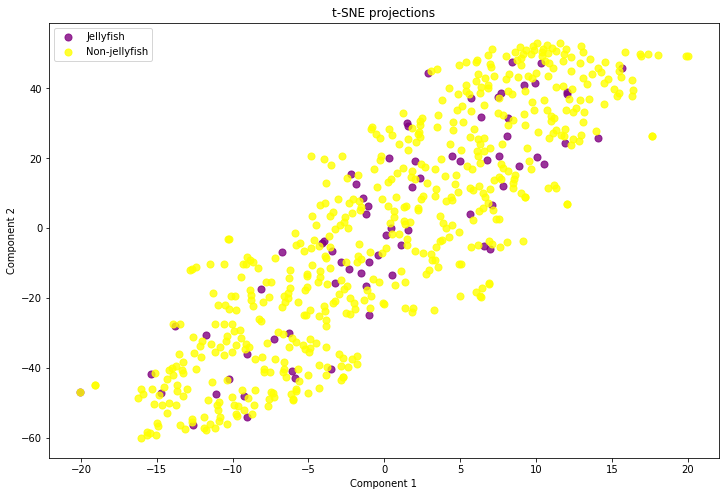

In [ ]:
tsne = TSNE(n_components=2)  # Use random_state=<int> for reproducible results.
pspecs_1d_tsne_reduced = tsne.fit_transform(pspec_data)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("t-SNE projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_embedding = tsne.embedding_[labels==1]
nj_embedding = tsne.embedding_[labels==0]
ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, c="purple", alpha=0.8, label="Jellyfish");
ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, c="yellow", alpha=0.8, label="Non-jellyfish");
ax.legend();

### Radially averaged 1D power spectrums

In [ ]:
pspecs_1d = []
for image in os.listdir(jellyfish_dir):
    if image.startswith("hst") and image.endswith(".fits"):
        hdu = fits.open(os.path.join(jellyfish_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_1d.append(pspec.ps1D)
jelly_1d_pspecs = np.array(pspecs_1d)

In [ ]:
np.savetxt("pspecs_jellyfish_1d.txt", jelly_1d_pspecs)

In [ ]:
pspecs_1d = []
halpha_dir = "stamps_Halpha/"
for image in os.listdir(halpha_dir):
    if image.startswith("hst") and image.endswith(".fits") and image != "hst_stamp_gal_60579.fits":
        hdu = fits.open(os.path.join(halpha_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_1d.append(pspec.ps1D)
pspecs = np.array(pspecs_1d)
np.savetxt("pspecs_halpha_1d.txt", pspecs)

In [ ]:
pspecs_1d = []
non_halpha_dir = "stamps_non_halpha/"
for image in os.listdir(non_halpha_dir):
    if image.startswith("hst") and image.endswith(".fits") and image != "hst_stamp_gal_60579.fits":
        hdu = fits.open(os.path.join(non_halpha_dir, image))[0]
        pspec = PowerSpectrum(hdu, header=hdu.header)
        pspec.run(verbose=False)
        pspecs_1d.append(pspec.ps1D)
pspecs = np.array(pspecs_1d)
np.savetxt("pspecs_non_halpha_1d.txt", pspecs)

In [ ]:
halpha1d = np.loadtxt("pspecs_halpha_1d.txt")
non_halpha1d = np.loadtxt("pspecs_non_halpha_1d.txt")
jelly_1d = np.loadtxt("pspecs_jellyfish_1d.txt"
                     )
pspecs_1d_data = np.vstack([halpha1d, non_halpha1d, jelly_1d])

pca = PCA(n_components=2)
pspec_1d_scaled = pca.fit_transform(pspecs_1d_data)

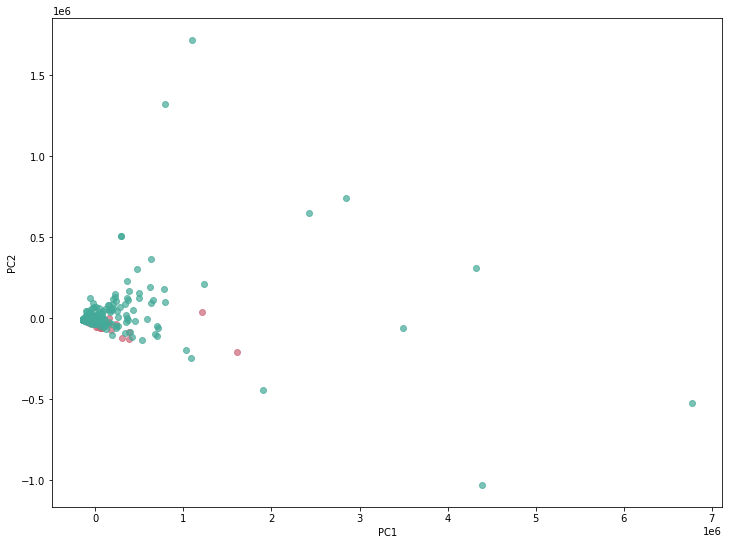

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

scatter_colors = ["purple", "yellow"]

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

jelly_comps = pspec_1d_scaled[labels==1]
non_jelly_comps = pspec_1d_scaled[labels==0]

# Scatter.
ax.scatter(jelly_comps[:, 0], jelly_comps[:, 1], c="#CC6677", alpha=0.7, label="jellyfish");
ax.scatter(non_jelly_comps[:, 0], non_jelly_comps[:, 1], c="#44AA99", alpha=0.7, label="non-jellyfish");

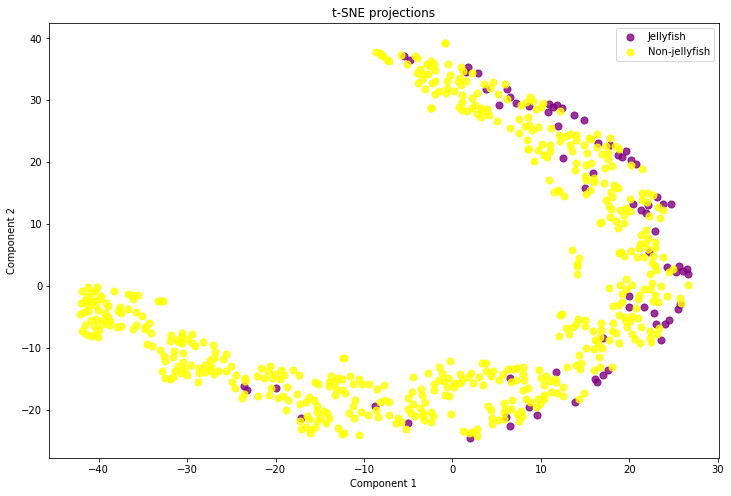

In [ ]:
tsne = TSNE(n_components=2)  # Use random_state=<int> for reproducible results.
pspecs_1d_tsne_reduced = tsne.fit_transform(pspecs_1d_data)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("t-SNE projections")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
j_embedding = tsne.embedding_[labels==1]
nj_embedding = tsne.embedding_[labels==0]
ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, c="purple", alpha=0.8, label="Jellyfish");
ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, c="yellow", alpha=0.8, label="Non-jellyfish");
ax.legend();

### Self-organizing Maps (using `minisom`)

In [ ]:
!pip install minisom

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8602 sha256=c86f0984c7d0c5544641082ad032e35d9d03f84aff20d5c5f0ded19b052079e2
  Stored in directory: /home/yash/.cache/pip/wheels/b2/b8/f9/08876fa31be00070d6a60686b9842e044d1a9b471e8d6772d4
Successfully built minisom
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from minisom import MiniSom

som_shape = (1, 2)
som = MiniSom(som_shape[0], som_shape[1], data_scaled.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

In [ ]:
som.train_batch(data_scaled, 750, verbose=True)

 [ 750 / 750 ] 100% - 0:00:00 left 
 quantization error: 184.52237957732538


In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data_scaled]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

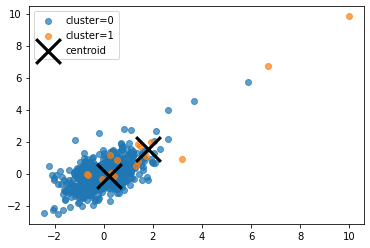

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data_scaled[cluster_index == c, 0],
                data_scaled[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=5, linewidths=35, color='k', label='centroid')
plt.legend(loc=0);

### Extra

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda_reduced = lda.fit_transform(data_scaled, labels)

plt.plot(lda_reduced);

Since there are only two classes, LDA cannot form more than 1 component. Hence, a 2D scatter plot, which is possible for other methods, is not possible for LDA.

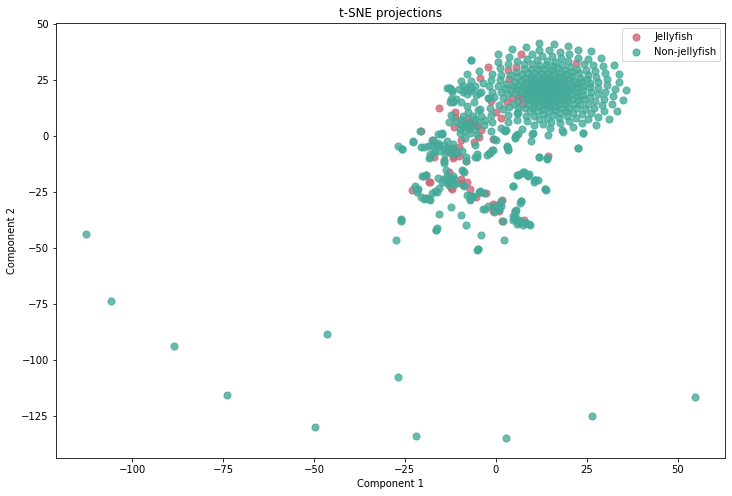

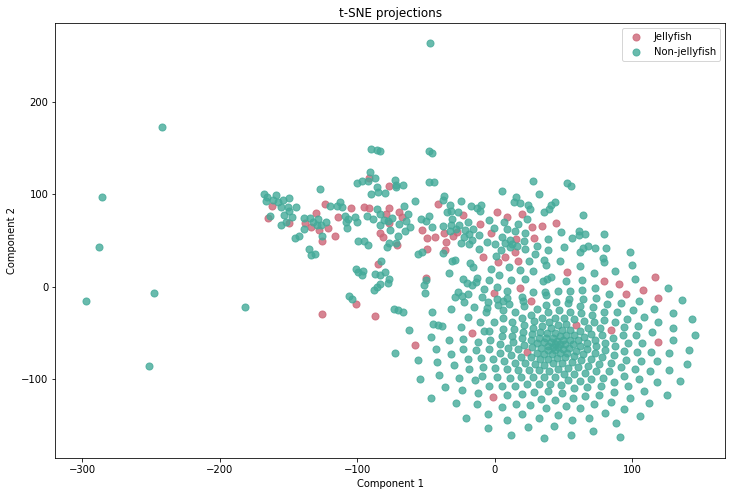

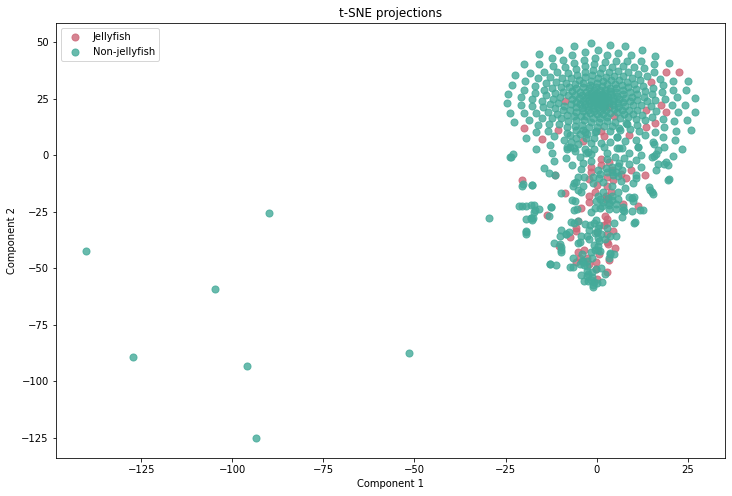

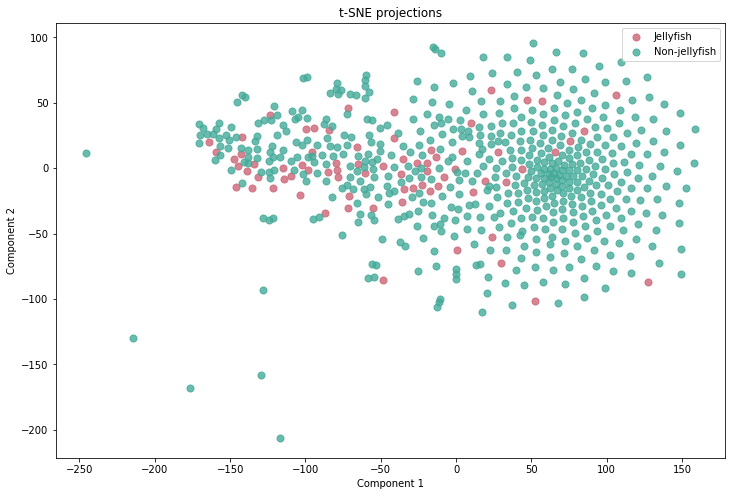

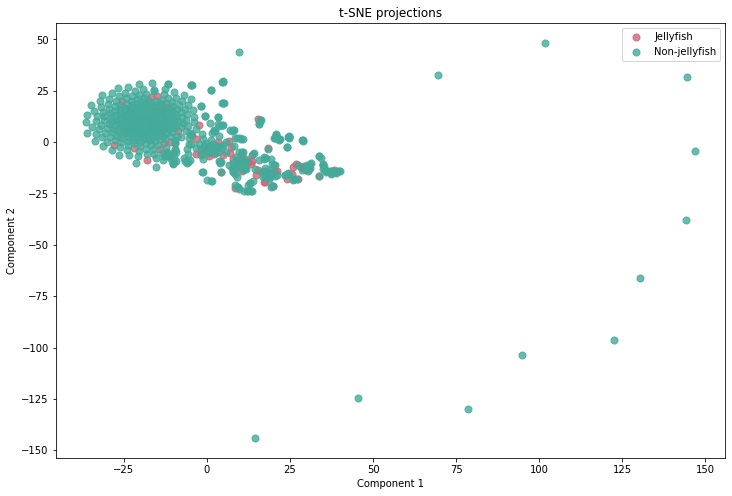

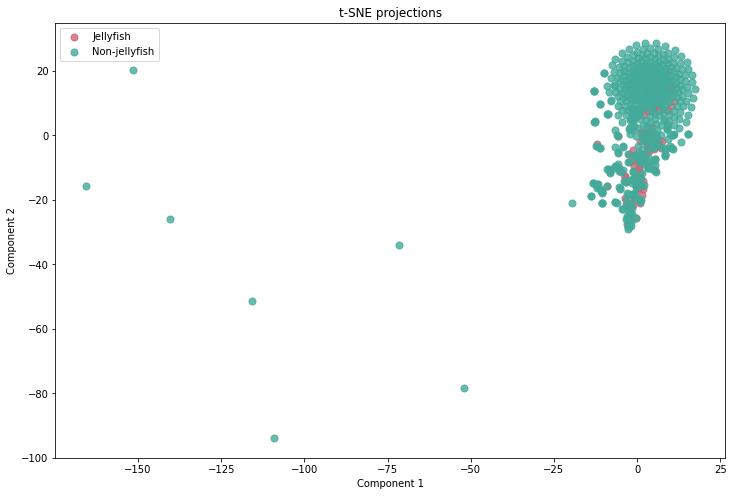

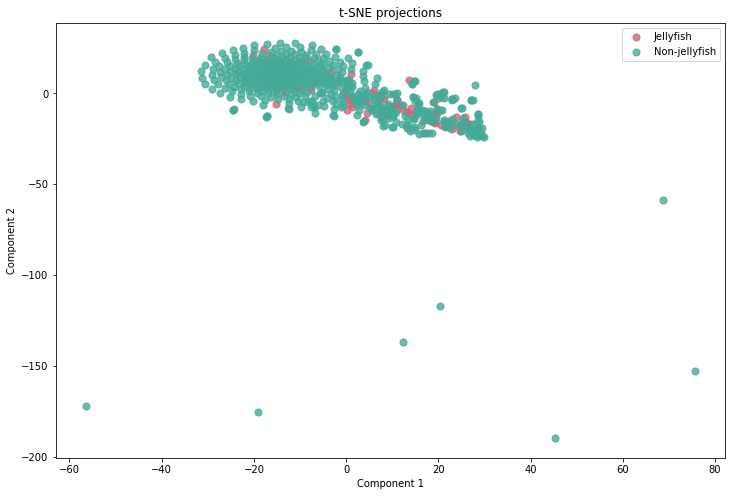

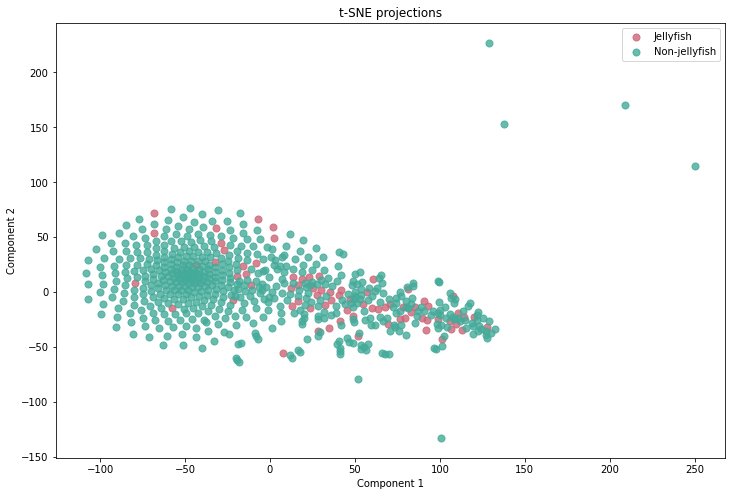

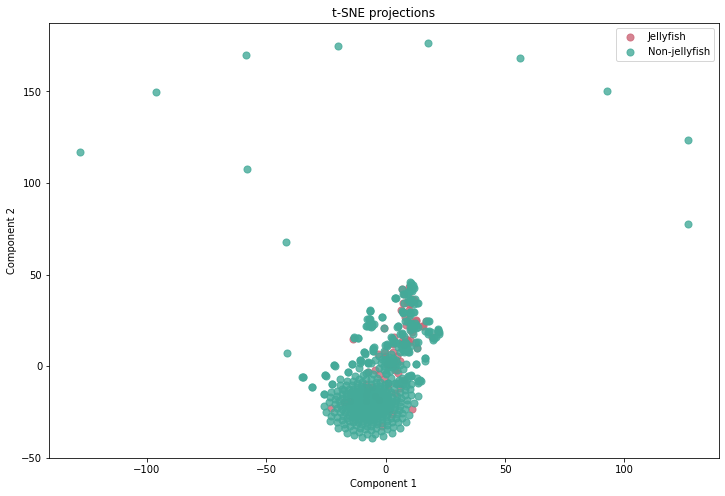

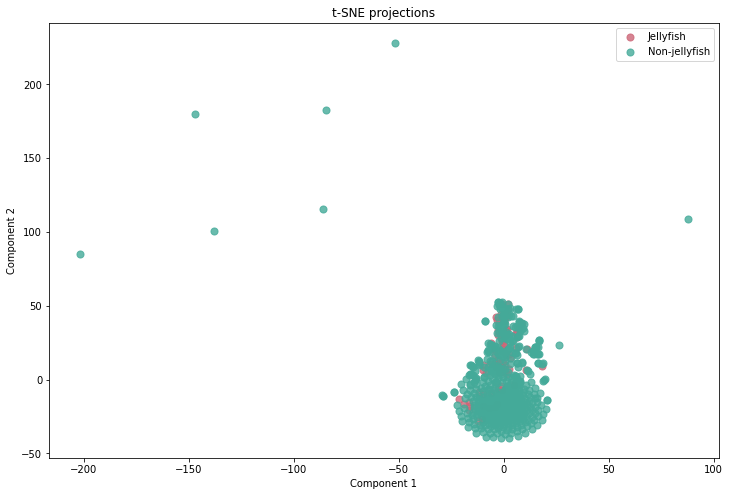

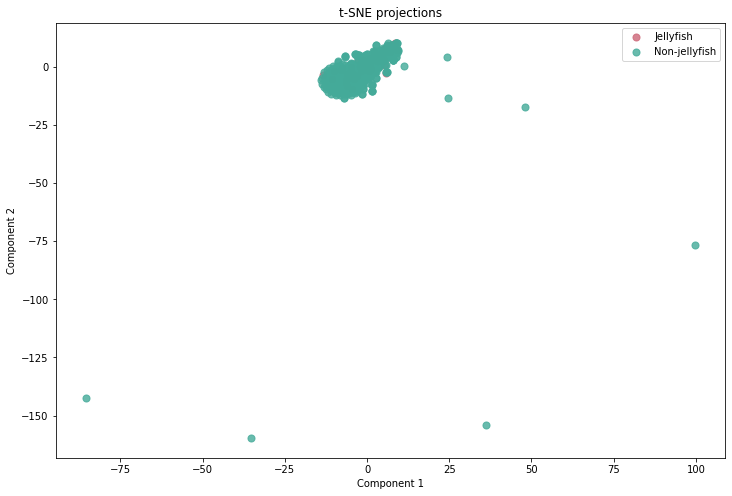

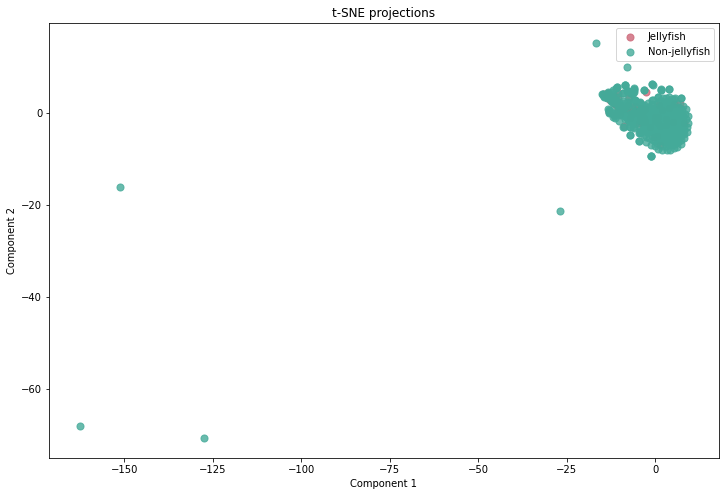

In [ ]:
iterations = [1000, 1500, 2000]
perplexities = [5, 10, 15, 20]
for iteration in iterations:
    for perplexity in perplexities:
        tsne = TSNE(n_components=2, n_iter=iteration, perplexity=perplexity)
        tsne.fit_transform(data_scaled)

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.set_title("t-SNE projections")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        j_embedding = tsne.embedding_[labels==1]
        nj_embedding = tsne.embedding_[labels==0]
        ax.scatter(j_embedding[:, 0], j_embedding[:, 1], s=50, c="#CC6677", alpha=0.8, label="Jellyfish");
        ax.scatter(nj_embedding[:, 0], nj_embedding[:, 1], s=50, c="#44AA99", alpha=0.8, label="Non-jellyfish");
        ax.legend();